In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.externals import joblib
from sklearn import preprocessing
from sklearn import mixture
from multiprocessing import Pool

In [2]:
# load in coverage data at ATAC peaks

coverage_file = 'islet.bams_ATAC.summary.sort.subpeak.tab'
coverage = pd.read_csv(coverage_file, sep='\t', header=0)
coverage['peak'] = coverage['#chrom'].apply(str) + ':' + coverage['start'].apply(str) + '-' + coverage['end'].apply(str)
coverage['peak_length'] = coverage['end'] - coverage['start']
coverage.drop(['#chrom', 'start','end'], axis=1, inplace=True)
coverage.set_index('peak', inplace=True)

In [3]:
# create new dataframe for normalized coverage

coverage_normalized = pd.DataFrame(coverage['peak_length'])
coverage_normalized['subpeak'] = coverage['subpeak']
#coverage_normalized['ATAC_signal'] = coverage['ATAC_signal']
coverage_normalized['norm_ATAC_signal'] = coverage['norm_ATAC_signal']

# first normalize to total read coverage

read_counts_file = 'read_coverage.txt'
read_counts = {line.split('\t')[0]: int(line.split('\t')[1]) for line in open(read_counts_file).read().splitlines()}
for key in read_counts.keys():
    coverage[key] = coverage[key]/read_counts[key]

# next subtract control (input ChIP) from the treatment

match_treatment_controls_file = 'match_treatment_to_controls.txt'
with open(match_treatment_controls_file) as f:
    for line in f.read().splitlines():
        treat = line.split('\t')[0]
        control = line.split('\t')[1]
        coverage_normalized['{}-{}'.format(treat, control)] = coverage[treat] - coverage[control]

## StandardScaler: scale the features to 0 mean and unit variance (z-score scaling)
# RobustScaler: scale the features to median and IQR (25%/75%)

coverage_scaler = preprocessing.RobustScaler()
coverage_scaler.fit(coverage_normalized)
coverage_normalized = pd.DataFrame(coverage_scaler.transform(coverage_normalized), 
                                   index=coverage_normalized.index, 
                                   columns=coverage_normalized.columns)

In [4]:
# Gaussian mixture model
# http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

# Covariance types:
## 'full' (each component has its own general covariance matrix),
## 'tied' (all components share the same general covariance matrix),
## 'diag' (each component has its own diagonal covariance matrix),
## 'spherical' (each component has its own single variance).


def run_mixture(n):
    model = {}
    cov_types = ['full']#, 'tied', 'diag', 'spherical']
    for cov in cov_types:
        model[cov] = mixture.GaussianMixture(n_components=n, 
                                        covariance_type=cov, 
                                        max_iter=200, 
                                        verbose=0).fit(coverage_normalized)
    return model

max_feat = 30
N = np.arange(1, max_feat+1)
with Pool(processes=10) as pool:
    models = pool.map(run_mixture, N)

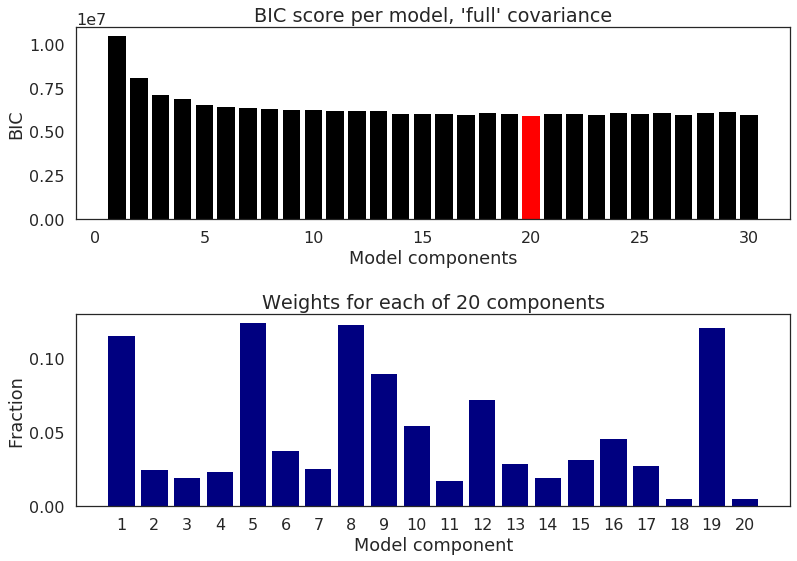

In [5]:
# get methods from the models

bic, weights, means, n_iter, loglk, status = {}, {}, {}, {}, {}, {}
for mod in models:
    for cov in mod.keys():
        bic[cov] = bic.get(cov, []) + [mod[cov].bic(coverage_normalized)]
        weights[cov] = weights.get(cov, []) + [mod[cov].weights_]
        means[cov] = means.get(cov, []) + [mod[cov].means_]
        n_iter[cov] = n_iter.get(cov, []) + [mod[cov].n_iter_]
        loglk[cov] = loglk.get(cov, []) + [mod[cov].lower_bound_]
        status[cov] = status.get(cov, []) + [mod[cov].converged_]

bic_val, n_bic = min((val, idx) for (idx, val) in enumerate(bic['full']))
weights_n_bic = weights['full'][n_bic]

plt.style.use('seaborn-white')
plt.style.use('seaborn-poster')
plt.clf()
fig, (ax1, ax2) = plt.subplots(2,1)
fig.subplots_adjust(hspace=.5)

# plot BIC (Bayesian Information Criterion) against number of components

a1_full = ax1.bar(np.arange(1,max_feat+1), bic['full'], label='full', color='black')
a1_full[n_bic].set_facecolor('red')
#bar_width=0.2
#ax1.bar(np.arange(1+bar_width,max_feat+1+bar_width), bic['tied'], label='tied', width=bar_width)
#ax1.bar(np.arange(1+2*bar_width,max_feat+1+2*bar_width), bic['diag'], label='diag', width=bar_width)
#ax1.bar(np.arange(1+3*bar_width,max_feat+1+3*bar_width), bic['spherical'], label='spherical', width=bar_width)
#ax1.legend(loc='upper right', shadow=True)
ax1.set_title('BIC score per model, \'full\' covariance')
ax1.set_xlabel('Model components')
ax1.set_ylabel('BIC')

# plot weights of the components for the model with the lowest BIC

ax2.bar(np.arange(1, len(weights_n_bic) + 1), weights_n_bic, color='navy')
ax2.set_xticks(np.arange(1, len(weights_n_bic) + 1))
ax2.set_title('Weights for each of {} components'.format(n_bic+1))
ax2.set_xlabel('Model component')
ax2.set_ylabel('Fraction')
plt.show()

In [58]:
# save the model with the lowest bic score by pickle
model_pickle = 'gmmodel.{}_components.pkl'.format(n_bic+1)
joblib.dump(models[n_bic]['full'], model_pickle)

# get the means for model with the lowest bic score
clusters = pd.DataFrame(means['full'][n_bic], columns=coverage_normalized.columns, index=np.arange(1,n_bic+2))
clusters

,peak_length,subpeak,norm_ATAC_signal,CTCF.BR1.Male.Pasquali-Input.BR1.Male.Pasquali,CTCF.BR2.Male.Pasquali-Input.BR1.Male.Pasquali,CTCF.BR3.Male.Pasquali-Input.BR1.Male.Pasquali,CTCF.BR1.Male.Stitzel-Input.BR3.Male.Stitzel,H3K27ac.BR1.Male.Parker-Input.BR1.Male.Parker,H3K27ac.BR2.Female.Parker-Input.BR3.Female.Parker,H3K27ac.BR1.Male.Pasquali-Input.BR1.Male.Pasquali,...,FOXA2.BR1.Male.Pasquali-Input.BR1.Male.Pasquali,FOXA2.BR2.Male.Pasquali-Input.BR1.Male.Pasquali,MAFB.BR1.Female.Pasquali-Input.BR1.Male.Pasquali,MAFB.BR2.Female.Pasquali-Input.BR1.Male.Pasquali,NKX2_2.BR1.Female.Pasquali-Input.BR1.Male.Pasquali,NKX2_2.BR2.Female.Pasquali-Input.BR1.Male.Pasquali,NKX6_1.BR1.Male.Pasquali-Input.BR1.Male.Pasquali,NKX6_1.BR2.Female.Pasquali-Input.BR1.Male.Pasquali,PDX1.BR1.Male.Pasquali-Input.BR1.Male.Pasquali,PDX1.BR2.Male.Pasquali-Input.BR1.Male.Pasquali
1,-0.072068,0.000000,0.057377,-0.199058,-0.148113,-0.194483,-0.209486,0.103384,-0.026563,-0.012408,...,-0.042880,-0.059820,-0.059153,-0.132879,-0.181375,-0.185411,-0.200625,-0.269130,-0.158776,-0.203612
2,1.314570,0.438904,3.407791,0.418804,0.752045,0.746681,0.546775,4.402938,2.288251,2.381509,...,0.415932,0.437421,0.374262,0.285652,1.776135,1.466243,1.753145,2.717348,0.987148,1.118038
3,1.504312,0.721404,1.804897,0.105715,0.386057,0.306521,0.244292,4.035186,2.186915,2.327767,...,1.232930,1.426810,0.784244,0.487178,1.433236,1.194578,0.472679,0.964555,0.537669,0.605652
4,0.523006,0.478101,0.226562,5.165229,6.059811,5.915171,3.716174,0.067969,0.204061,0.242675,...,1.870093,2.071714,2.000476,1.582185,0.819872,1.039965,1.125351,0.644542,1.280204,1.292160
5,-0.318047,0.000000,-0.280752,-0.156273,-0.166383,-0.203170,-0.218092,-0.099633,-0.332044,-0.275612,...,-0.288688,-0.241254,-0.292377,-0.227014,-0.436749,-0.427723,-0.370285,-0.417701,-0.306489,-0.360203
6,0.863535,0.401717,1.338984,0.076992,0.197783,0.129286,0.014567,2.559721,1.016541,1.235656,...,-0.085952,-0.053660,0.022108,-0.046291,0.252413,0.065851,-0.072309,0.383338,-0.015808,0.030240
7,0.445261,0.274127,0.580558,-0.147754,0.003149,-0.041974,-0.008202,0.922731,1.169648,1.083817,...,1.107683,1.147459,1.379457,1.070547,0.654571,0.740280,0.630453,0.501677,0.765718,0.640320
8,0.178808,0.000000,0.302874,-0.201139,-0.074864,-0.113310,0.052327,0.061863,0.348038,0.456183,...,2.367265,2.620636,2.053230,1.692704,1.142487,1.346954,1.429358,0.917889,1.651076,1.624959
9,-0.259093,0.000000,-0.135771,6.527570,7.448315,7.231605,4.526144,-0.069290,-0.314141,-0.266894,...,-0.005020,0.004539,0.012458,-0.048946,-0.088762,-0.009696,-0.017476,-0.128165,-0.037085,-0.014063
10,-0.000427,0.000000,0.257121,0.047080,0.123551,0.034468,-0.080549,0.777757,0.071151,0.077435,...,-0.263455,-0.209103,-0.188964,-0.171547,-0.236716,-0.291357,-0.310257,-0.115818,-0.244825,-0.277460


/usr/local/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


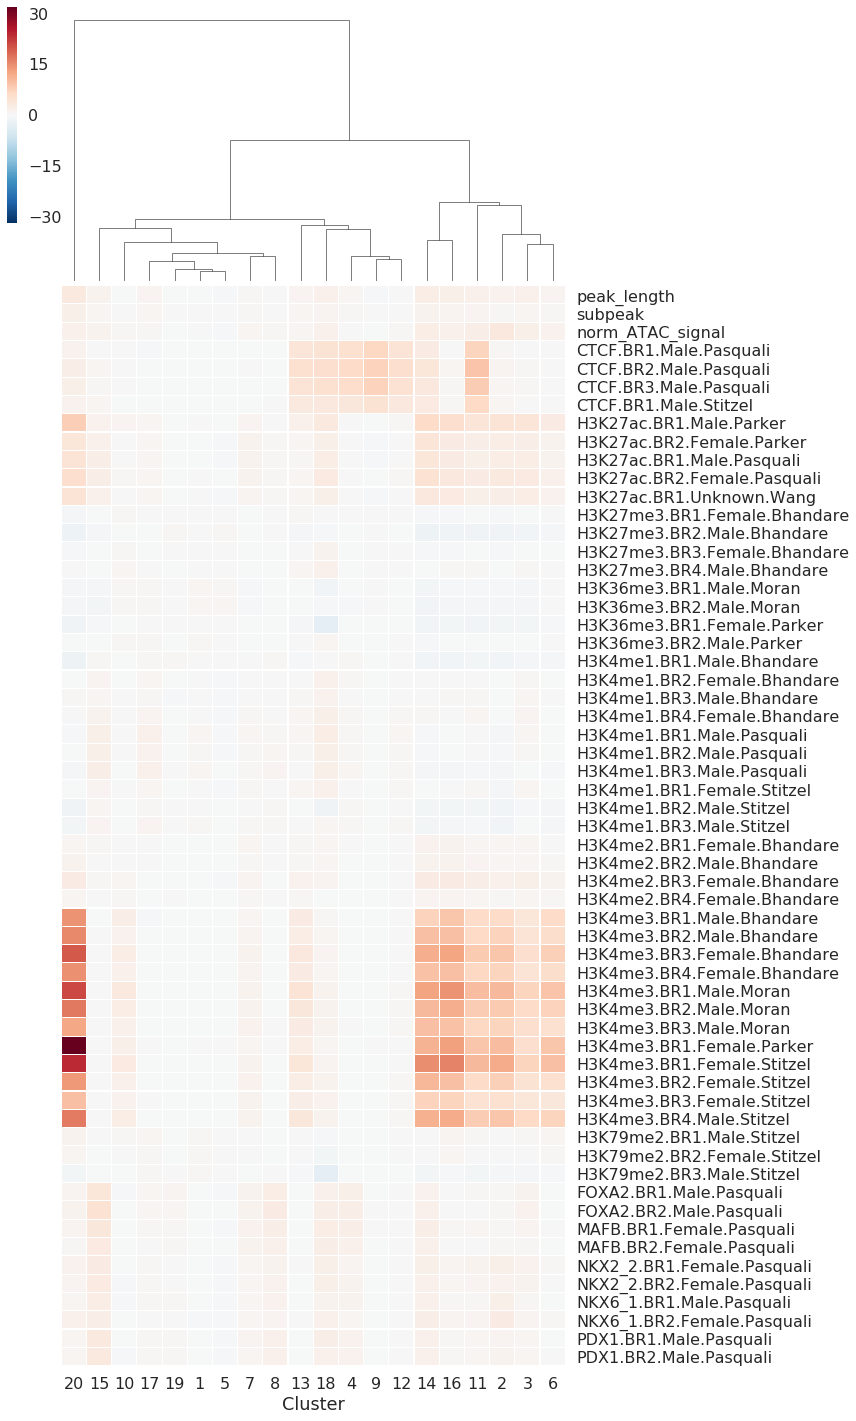

In [9]:
plt.clf()
# before getting rid of high signal cluster
clusters_transpose = data=clusters.transpose()
g = sns.clustermap(clusters_transpose, 
                   row_cluster=False, 
                   linewidths=0.1, 
                   figsize=(10,25),
                   yticklabels=[label.split('-')[0] for label in clusters_transpose.index.values])
g.ax_heatmap.set_xlabel('Cluster')
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()
#models[n_bic]['full'].predict_proba(coverage_normalized)

/usr/local/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


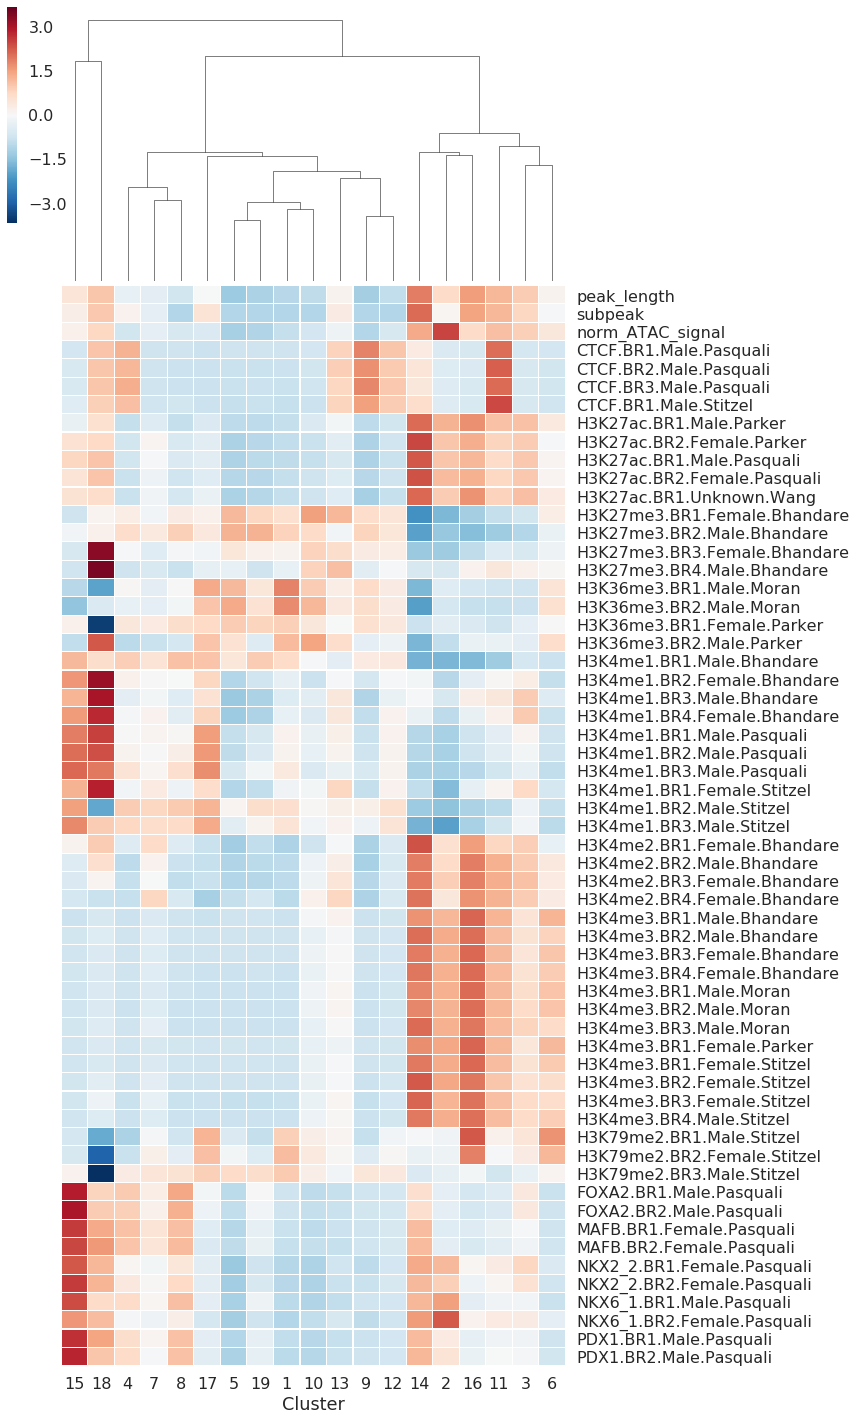

In [60]:
plt.clf()
# drop high signal cluster
drop_cluster = [20]
clusters_transpose_dropped = clusters.transpose().drop(drop_cluster, axis=1)


g2 = sns.clustermap(data=clusters_transpose_dropped,
                    row_cluster=False, 
                    linewidths=0.1, 
                    figsize=(10,25),
#                    standard_scale=0,
                    z_score=0,
                    yticklabels=[label.split('-')[0] for label in clusters_transpose_dropped.index.values])
g2.ax_heatmap.set_xlabel('Cluster')
plt.setp(g2.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

In [13]:
clusters_transformed = pd.DataFrame(coverage_scaler.inverse_transform(means['full'][n_bic]), 
             columns=coverage_normalized.columns, index=np.arange(1,n_bic+2))
clusters_transformed

,peak_length,subpeak,norm_ATAC_signal,CTCF.BR1.Male.Pasquali-Input.BR1.Male.Pasquali,CTCF.BR2.Male.Pasquali-Input.BR1.Male.Pasquali,CTCF.BR3.Male.Pasquali-Input.BR1.Male.Pasquali,CTCF.BR1.Male.Stitzel-Input.BR3.Male.Stitzel,H3K27ac.BR1.Male.Parker-Input.BR1.Male.Parker,H3K27ac.BR2.Female.Parker-Input.BR3.Female.Parker,H3K27ac.BR1.Male.Pasquali-Input.BR1.Male.Pasquali,...,FOXA2.BR1.Male.Pasquali-Input.BR1.Male.Pasquali,FOXA2.BR2.Male.Pasquali-Input.BR1.Male.Pasquali,MAFB.BR1.Female.Pasquali-Input.BR1.Male.Pasquali,MAFB.BR2.Female.Pasquali-Input.BR1.Male.Pasquali,NKX2_2.BR1.Female.Pasquali-Input.BR1.Male.Pasquali,NKX2_2.BR2.Female.Pasquali-Input.BR1.Male.Pasquali,NKX6_1.BR1.Male.Pasquali-Input.BR1.Male.Pasquali,NKX6_1.BR2.Female.Pasquali-Input.BR1.Male.Pasquali,PDX1.BR1.Male.Pasquali-Input.BR1.Male.Pasquali,PDX1.BR2.Male.Pasquali-Input.BR1.Male.Pasquali
1,333.532679,1.000000,0.199506,-6.708940e-08,-5.082581e-08,-4.783750e-08,3.409229e-08,7.460706e-07,7.035445e-07,7.122654e-07,...,4.153502e-07,2.119762e-07,3.138299e-07,8.770632e-09,7.406987e-07,5.089757e-07,2.078940e-07,5.171685e-08,1.717201e-07,1.890289e-07
2,727.337912,1.438904,0.808089,1.805679e-07,7.398211e-07,4.906680e-07,6.945431e-07,1.741671e-05,5.184465e-06,7.183530e-06,...,1.012935e-06,7.396786e-07,8.561841e-07,1.781376e-07,5.551956e-06,3.557220e-06,1.969936e-06,1.674505e-06,1.359274e-06,1.437786e-06
3,781.224542,1.721404,0.516933,5.507270e-08,4.183581e-07,2.388216e-07,4.303813e-07,1.599082e-05,4.988302e-06,7.038253e-06,...,2.077045e-06,1.789680e-06,1.369214e-06,2.596894e-07,4.709163e-06,3.055842e-06,8.151249e-07,7.220744e-07,8.934654e-07,9.536588e-07
4,502.533842,1.478101,0.230238,2.083075e-06,5.401858e-06,3.447921e-06,3.462415e-06,6.087563e-07,1.149978e-06,1.401809e-06,...,2.906926e-06,2.474091e-06,2.891145e-06,7.028058e-07,3.201610e-06,2.770494e-06,1.403749e-06,5.481865e-07,1.662975e-06,1.602304e-06
5,263.674510,1.000000,0.138087,-4.993993e-08,-6.687280e-08,-5.280831e-08,2.657624e-08,-4.108293e-08,1.122082e-07,7.689351e-10,...,9.519404e-08,1.942753e-08,2.198593e-08,-2.932278e-08,1.130275e-07,6.177162e-08,5.488307e-08,-2.901372e-08,1.864069e-08,4.107416e-08
6,599.243852,1.401717,0.432302,4.355968e-08,2.529898e-07,1.374134e-07,2.297597e-07,1.027001e-05,2.722741e-06,4.086047e-06,...,3.592495e-07,2.185131e-07,4.155159e-07,4.381027e-08,1.806884e-06,9.726974e-07,3.236182e-07,4.062539e-07,3.198816e-07,4.099830e-07
7,480.454038,1.274127,0.294539,-4.652515e-08,8.203372e-08,3.942334e-08,2.098755e-07,3.922921e-06,3.019119e-06,3.675592e-06,...,1.913916e-06,1.493215e-06,2.114033e-06,4.957610e-07,2.795324e-06,2.217403e-06,9.574164e-07,4.705567e-07,1.129799e-06,9.864153e-07
8,404.781436,1.000000,0.244099,-6.792351e-08,1.351223e-08,-1.393003e-09,2.627358e-07,5.850828e-07,1.428683e-06,1.978966e-06,...,3.554474e-06,3.056641e-06,2.957158e-06,7.475293e-07,3.994548e-06,3.337062e-06,1.677922e-06,6.967173e-07,2.047321e-06,1.916748e-06
9,280.417604,1.000000,0.164422,2.629141e-06,6.621441e-06,4.201145e-06,4.169771e-06,7.656346e-08,1.468635e-07,2.433548e-08,...,4.646612e-07,2.802775e-07,4.034412e-07,4.273582e-08,9.683273e-07,8.332698e-07,3.730697e-07,1.283141e-07,2.978315e-07,3.681232e-07
10,353.878687,1.000000,0.235788,3.157001e-08,1.877886e-07,8.316118e-08,1.466944e-07,3.360814e-06,8.926950e-07,9.551287e-07,...,1.280593e-07,5.354808e-08,1.513918e-07,-6.876957e-09,6.046801e-07,3.134453e-07,1.090207e-07,1.350229e-07,8.254431e-08,1.192536e-07


In [ ]:
# Use a Bayesian Gaussian mixture to estimate the number of components
# Parameters that might need to be changed: weight_concentration_prior?
# http://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html

def run_bayesian_mixture(weight_conc_prior):
    bgmm_model = mixture.BayesianGaussianMixture(n_components=50,
                                                 covariance_type='full',
                                                 weight_concentration_prior=weight_conc_prior,
                                                 weight_concentration_prior_type='dirichlet_process',
                                                 max_iter=1500,
                                                 verbose=2,
                                                 verbose_interval=10)
    bgmm_model.fit(coverage_normalized)
    print('Finishing up model with weight concentration prior {}'.format(weight_conc_prior))
    return bgmm_model

weight_concs = [1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
with Pool(processes=len(weight_concs)) as pool:
    bgmm_models = pool.map(run_bayesian_mixture, weight_concs)

Initialization 0
Initialization 0
Initialization 0
Initialization 0
Initialization 0
Initialization 0
  Iteration 0	 time lapse 42.22709s	 ll change inf
  Iteration 0	 time lapse 42.23026s	 ll change inf
  Iteration 0	 time lapse 47.46613s	 ll change inf
  Iteration 0	 time lapse 48.05583s	 ll change inf
  Iteration 0	 time lapse 49.55774s	 ll change inf
  Iteration 0	 time lapse 50.88124s	 ll change inf
  Iteration 10	 time lapse 185.03192s	 ll change 4332.13864
  Iteration 10	 time lapse 184.73632s	 ll change 4333.40768
  Iteration 10	 time lapse 308.62079s	 ll change 4332.12946
  Iteration 10	 time lapse 363.97247s	 ll change 4332.62779
  Iteration 10	 time lapse 362.16688s	 ll change 4332.13986
  Iteration 10	 time lapse 397.10240s	 ll change 4332.15425
  Iteration 20	 time lapse 507.19402s	 ll change 945.79099
  Iteration 20	 time lapse 689.54238s	 ll change 945.29694
  Iteration 20	 time lapse 700.71169s	 ll change 976.14859
  Iteration 20	 time lapse 554.05710s	 ll change 945.26

In [42]:
model_predict = models[n_bic]['full'].predict(coverage_normalized).tolist()
model_predict = [m+1 for m in model_predict]
clusters_predict = ['Cluster_{}'.format(c) for c in model_predict]
model_out = 'model.{}_clusters.predictions.txt'.format(n_bic+1)
clusters_predict
with open(model_out, 'w') as f:
    f.write('\n'.join(clusters_predict))